# Harmonic Analysis of a Tidal Signal and Forecast
The complexe tide signal can be decomposed into harmonic oscillations. This was first described by Pierre Simon Laplace during the XVIII century. From its theoretical work, one hundred year after, the physician Thomson designed the first instrument to predict them. One prototype of the instrument is displayed below. Each gear represent one constituent of the tide (the bigger the gear, the longer the period of the constituent). A single crank turned all of the gears simultaneously, having the effect of summing each of the cosine curves. As the user turned the crank, a pencil draw the resulting complex curve on a moving roll of paper. Knowing the initial phase of the components (where we are on Earth and when) allow to forecast the tides for one year after four hours of effort.

In [1]:
import numpy as np
from IPython.display import Image
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd

import utide

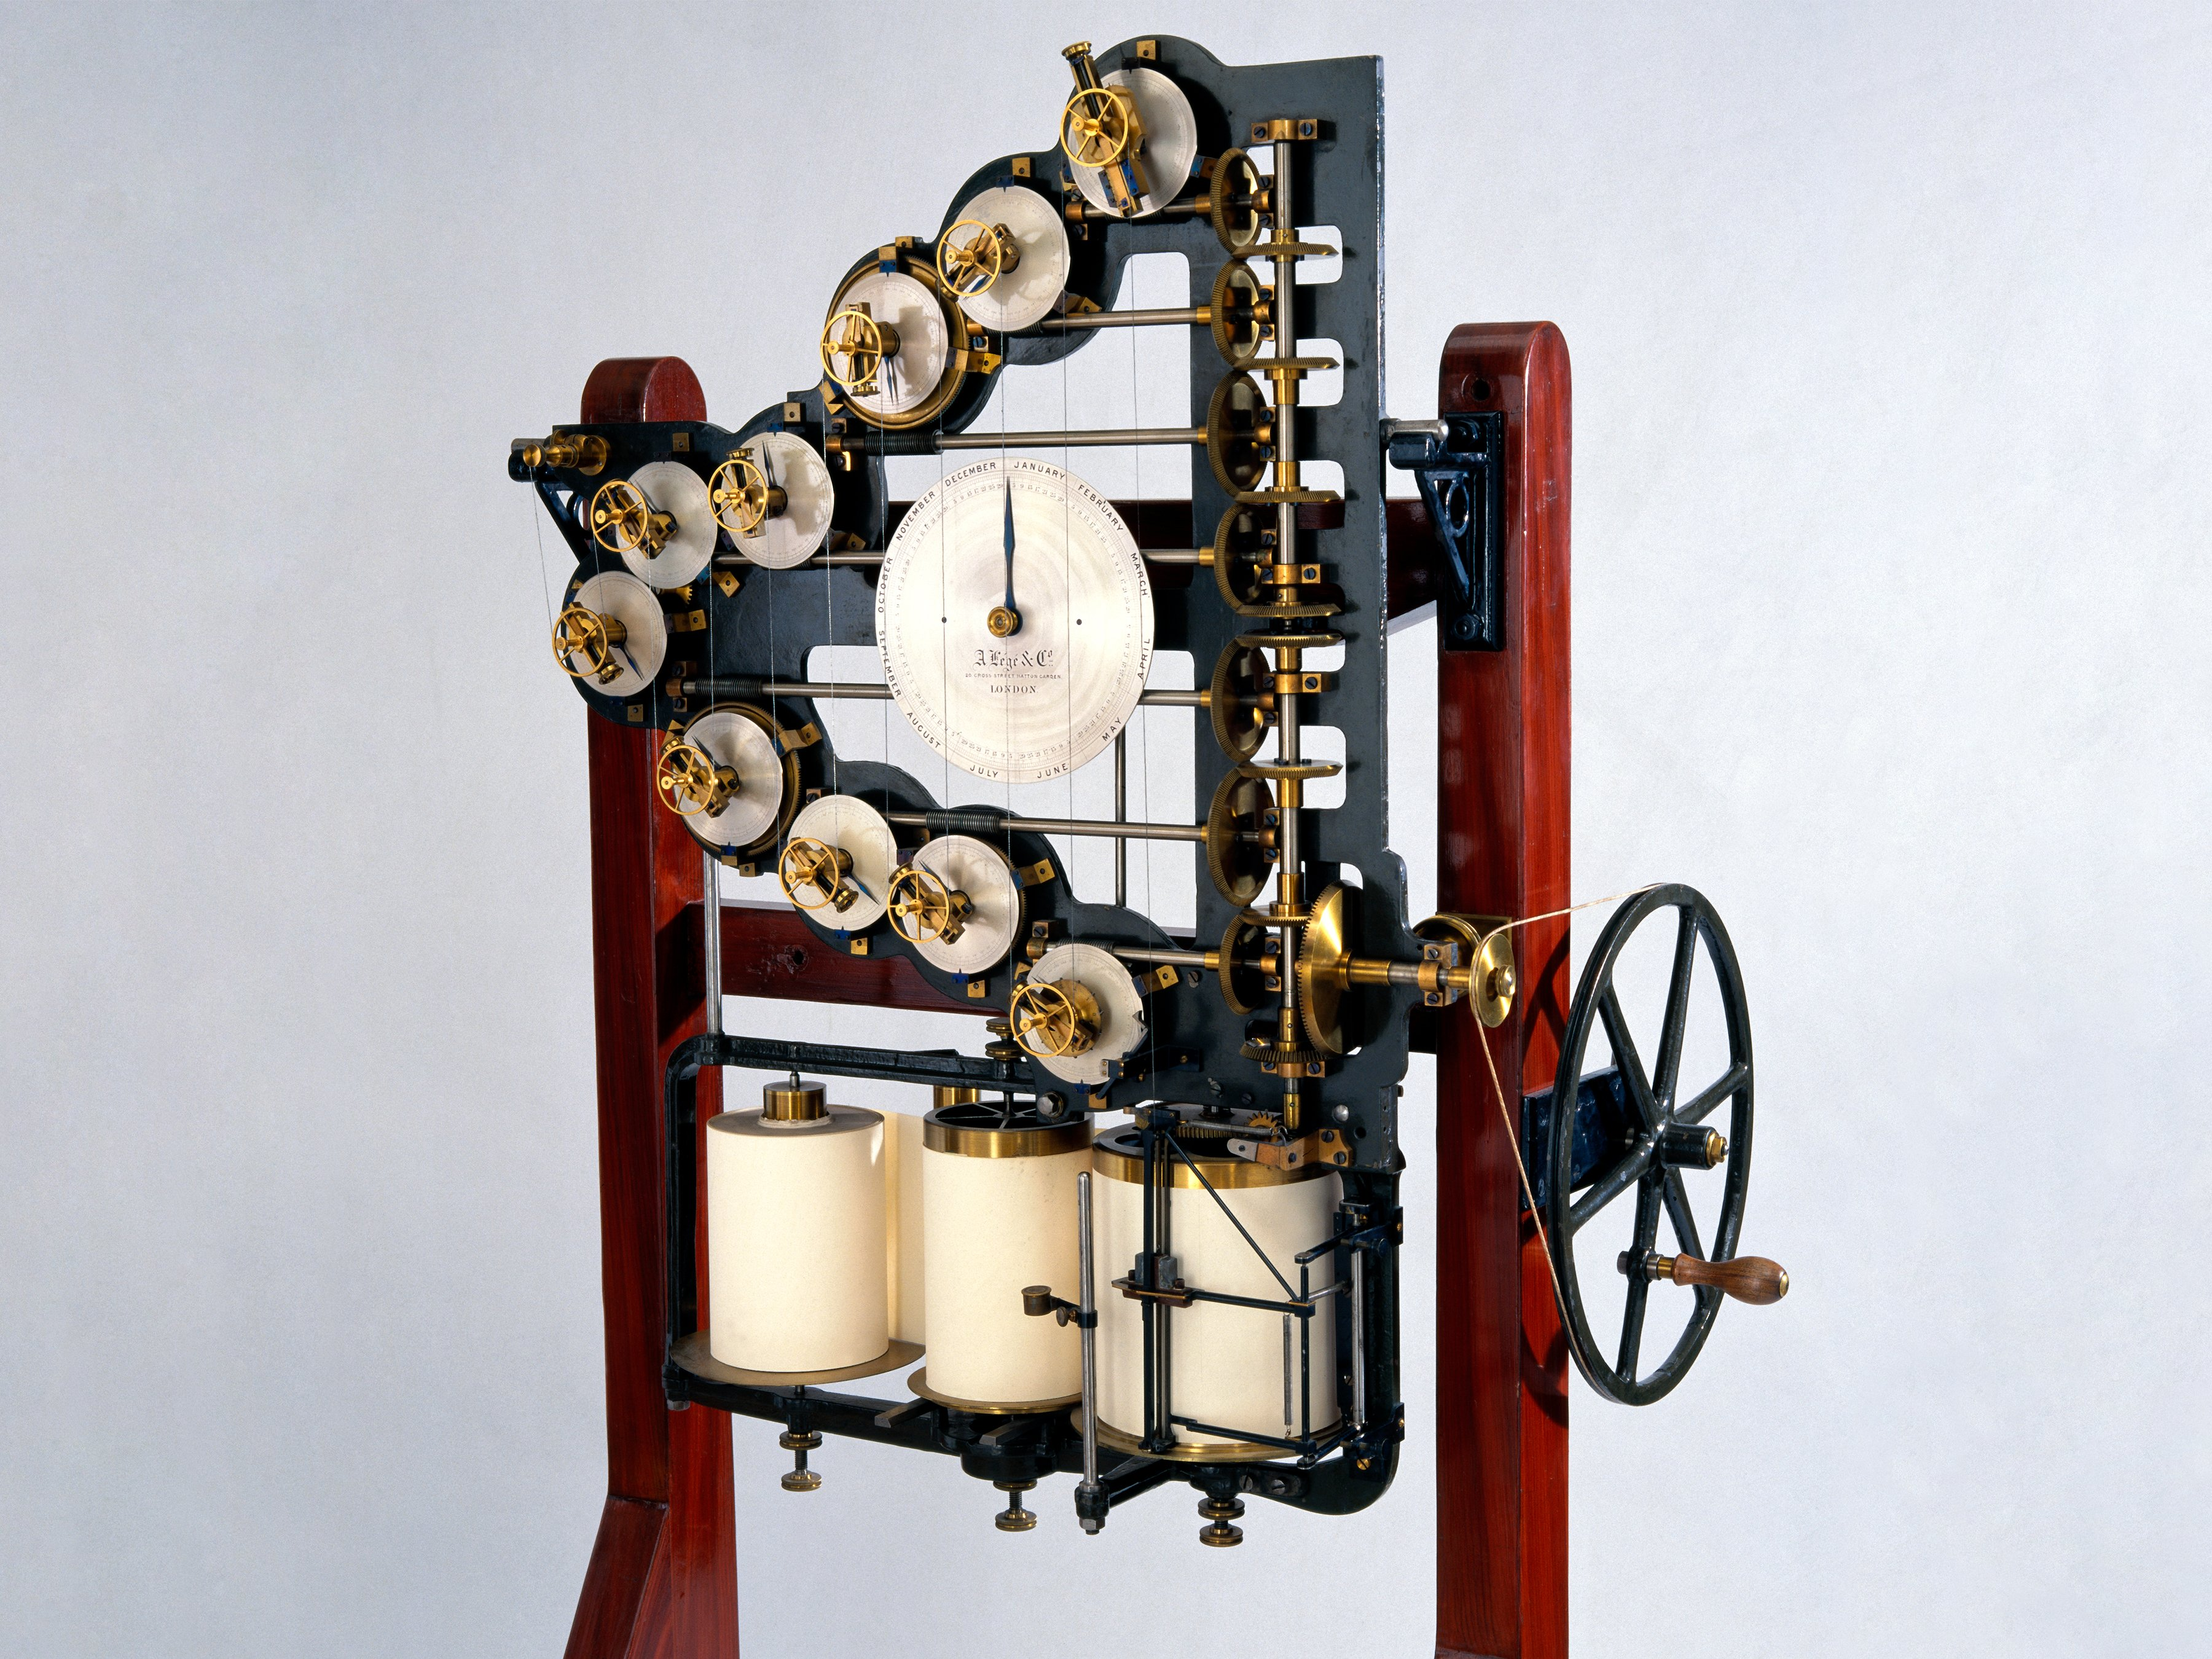

In [2]:
Image(filename="tide_instrument.jpg", width=700)

If you refer to the previous [notebook](./tidal_analysis.ipynb) (or in the litterature in general), you may have noticed that several tidal harmonics lie very close to one another in frequency (for instance, M2 and S2). This raises the question of how significant the resulting variations in water level are for these harmonics. More generally, one may ask: can we predict the total change in water elevation resulting from the tide over long timescales? The answer is yes.

One can forecast the complexe tidal signal at a given location based on a **harmonic analysis**. The tidal signal can be expresses as:

ℎ(𝑡) = 𝑍0 + ∑[𝐻𝑖 cos(𝜎𝑖𝑡 − $\varphi_i$). With:

- 𝑍0 the mean sea level
  
- 𝐻𝑖 the amplitude of the tidal constituent i

  
- 𝜎𝑖 the angular velocity (or frequency) of the tidal constituent i

  
- $\varphi_i$ the phase of the tidal constituent i

  
- t is the time

and the sum symbol is apply on all tidal constituents.

A necessary condition for tidal forecasting at a given location is the availability of prior observations of water level elevation. The longer the initial time record, the more accurate the forecast. The optimal record length is approximately 19 years, corresponding to a full nodal lunar cycle. However, such long records are relatively rare across coastal stations.

### Load Data and Plot

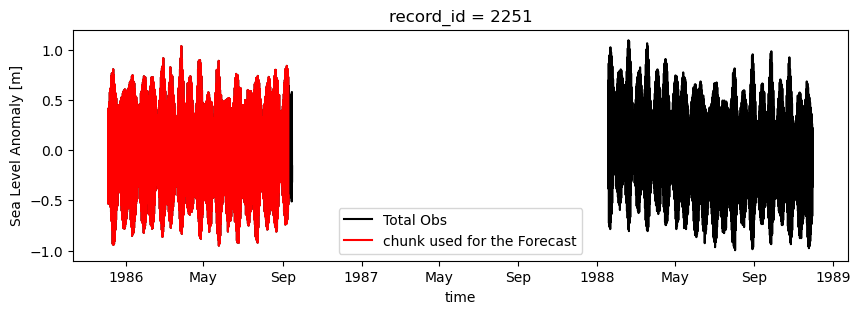

In [3]:
#########
# --- Here we load the different constituents of the tide
#########
nb_obs = 6700 # number of observation used for forecast

signal = xr.open_dataset('./data/tide_SaoTome.nc')
signal = signal.isel(record_id = 0)

mean_offset = signal.sea_level.mean(dim = 'time') # mean water elevation > 0

signal_offsetted = signal.sea_level - mean_offset # center the signal, get the anomaly
signal_offsetted = signal_offsetted/1_000 # switch from mm ->m

fig, ax = plt.subplots(figsize = (10, 3))
signal_offsetted.plot(ax = ax, color = 'k', label = 'Total Obs') # plot the total signal

signal_offsetted[:nb_obs].plot(ax = ax, color = 'r', label = 'chunk used for the Forecast')

ax.set_ylabel('Sea Level Anomaly [m]')
ax.legend()

### Use Utide for harmonics reconstructions:
We want to fill the gap in the data and gauge how accurate our forecast is based on the second half of the signal. We use the first half of the signal to initial the forecast

In [4]:
#########
# --- get the coefficient (the tidal harmonics)
#########
coef = utide.solve(
    signal_offsetted.time[:nb_obs],
    signal_offsetted[:nb_obs].values,
    lat=signal.lat.values,
    method="ols",
    conf_int="none",
    verbose=False
)

# A focus on M2 (the dominant harmonic (?))
coef_M2K1 = utide.solve(
    signal_offsetted.time[:nb_obs],
    signal_offsetted[:nb_obs].values,
    lat=signal.lat.values,
    method="ols",
    conf_int="none",
    verbose=False,
    constit = {'M2', 'K1'}    
)
#########
# --- Reconstruct the water level
#########
tide = utide.reconstruct(signal_offsetted.time, coef, verbose=False)
tide_M2K1 = utide.reconstruct(signal_offsetted.time, coef_M2K1, verbose=False)

Text(0, 0.5, 'Obs - Prediction')

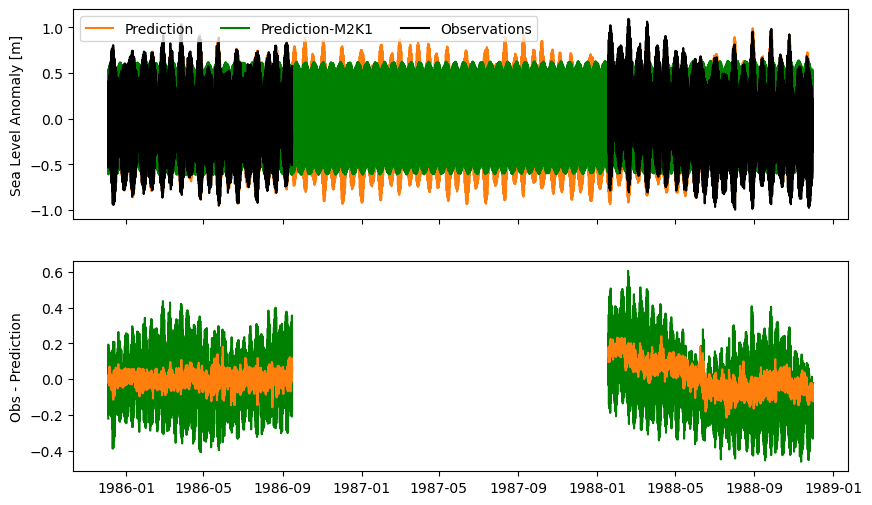

In [5]:
fig, axes = plt.subplots(figsize = (10, 6), nrows = 2, sharex = True)
ax = axes[0]
# signal_offsetted.plot(ax = ax, color = 'k', label = 'Total Obs') # plot the total signal
ax.plot(tide.t_in, tide.h, label="Prediction", color="C1")
ax.plot(tide_M2K1.t_in, tide_M2K1.h, label="Prediction-M2K1", color="green")

ax.plot(signal_offsetted.time, signal_offsetted, label="Observations", color="k")
ax.legend(ncols = 3)
ax.set_ylabel('Sea Level Anomaly [m]')

ax = axes[1]
ax.plot(tide.t_in, (signal_offsetted-tide_M2K1.h), color="green")
ax.plot(tide.t_in, (signal_offsetted-tide.h), color="C1")

ax.set_ylabel('Obs - Prediction')

Thanks to harmonic analysis, data gaps can be filled. However, the forecast quality remains limited even if we are considering all harmonics, as seen in the second half of the observation period. The difference between the observed and predicted water level anomalies reaches nearly 1/3 of the observed signal ($\sim$ January 1988). This quality further deteriorates when considering only the M2 and S2 harmonics, even though they are the dominant constituents. 

This lack of accuracy is likely due to the short initial time record used for the prediction. It is also possible that it may arises from systematic errors associated with the instrument itself.